In [1]:
import os
import sys
import numpy as np
import pandas as pd
import math
import sys
import pickle
import csv

import dask.dataframe as dd
from dask.distributed import Client

import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.nn import PyroModule
from pyro.infer import Predictive

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

sys.path.insert(0, '/home/djl34/lab_pd/kl/git/KL/scripts')
import raklette
from run_raklette import run_raklette
from run_raklette import TSVDataset
import post_analysis

sys.path.insert(0, '/home/djl34/lab_pd/simulator/code')
from others import round_sig

import seaborn as sns
import matplotlib.pyplot as plt

##############################################################################################################
## Useful transformations
####################################################
pad = torch.nn.ConstantPad1d((1,0), 0.)           # Add a 0 to a tensor
softmax = torch.nn.Softmax(-1)                    # softmax transform along the last dimension
relu = torch.nn.ReLU()                            # map everything < 0 -> 0
order_trans = dist.transforms.OrderedTransform()  # y_0=x_0; y_i=y_0+sum_j=1^i exp(x_j) [not really used anymore, weird properties]


KL_data_dir = "/home/djl34/lab_pd/kl/data"
scratch_dir = "/n/scratch/users/d/djl34"

base_set = ["A", "C", "T", "G"]
chrom_set = [str(x) for x in range(1, 23)]

file_directory = "single_feature/zoonomia/"

/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
client = Client()

## check convergence

In [3]:
chrom_set = ["2"]

header_names = ["zoonomia_"]

interval_list = []

interval_list = range(10)
interval_list = [x/10 for x in interval_list]

interval_list = [str(x) + "_" + str(round_sig(x + 0.1, 1)) for x in interval_list]

filename_list_cov = [os.path.join(KL_data_dir, "raklette_output/" + file_directory + "gene_edges_"+ interval +"_chr_{chrom}_sample_10000000_chunk_100000_covonly_lr_{learning_rate}_gamma_{gamma}_epoch_{epoch}_covprior_{cov_prior}_original") for interval in interval_list]
filename_list_nn = [os.path.join(KL_data_dir, "raklette_output/" + file_directory + "gene_edges_"+ interval +"_chr_{chrom}_sample_10000000_chunk_100000_covonly_lr_{learning_rate}_gamma_{gamma}_epoch_{epoch}_covprior_{cov_prior}_neural_net") for interval in interval_list]


filename_list = filename_list_cov

filename_list = [filename.replace("{learning_rate}", str(0.01)) for filename in filename_list]
filename_list = [filename.replace("{gamma}", str(0.5)) for filename in filename_list]
filename_list = [filename.replace("{epoch}", str(50)) for filename in filename_list]
filename_list = [filename.replace("{cov_prior}", str(0.1)) for filename in filename_list]
filename_list_cov = [filename.replace("{chrom}", str(chromosome)) for filename in filename_list for chromosome in chrom_set]

filename_list = filename_list_nn

filename_list = [filename.replace("{learning_rate}", str(0.01)) for filename in filename_list]
filename_list = [filename.replace("{gamma}", str(0.5)) for filename in filename_list]
filename_list = [filename.replace("{epoch}", str(50)) for filename in filename_list]
filename_list = [filename.replace("{cov_prior}", str(0.1)) for filename in filename_list]
filename_list_nn = [filename.replace("{chrom}", str(chromosome)) for filename in filename_list for chromosome in chrom_set]


### both seem to converge well

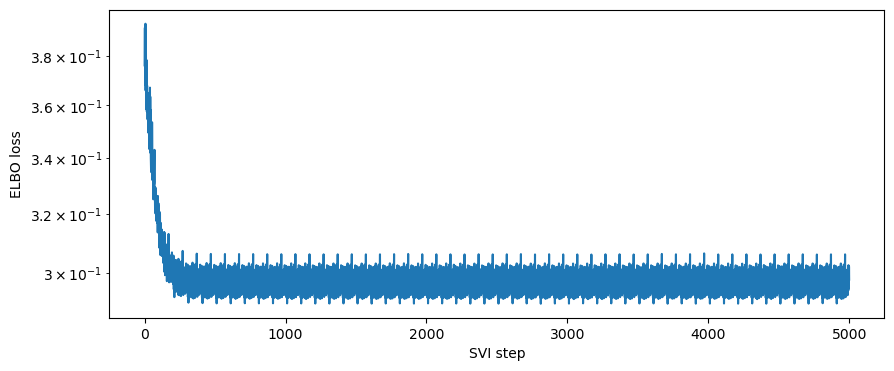

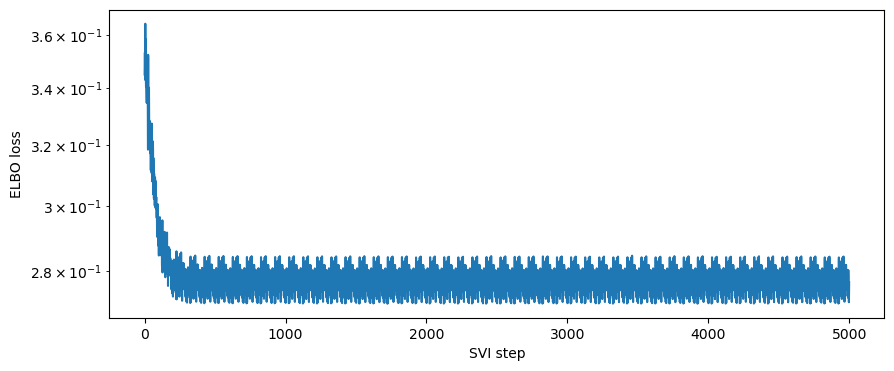

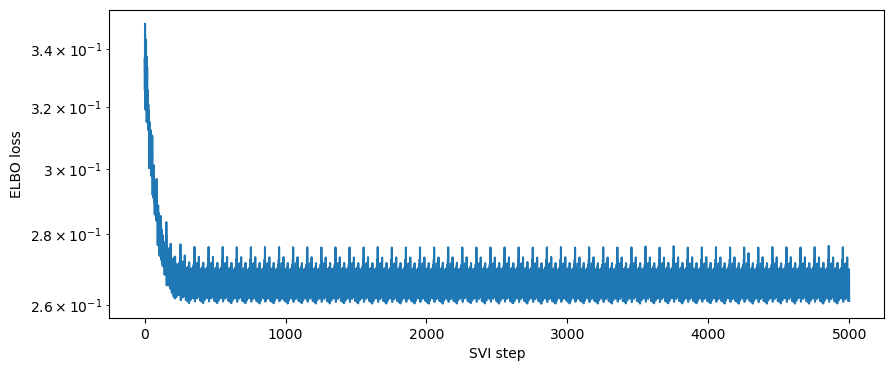

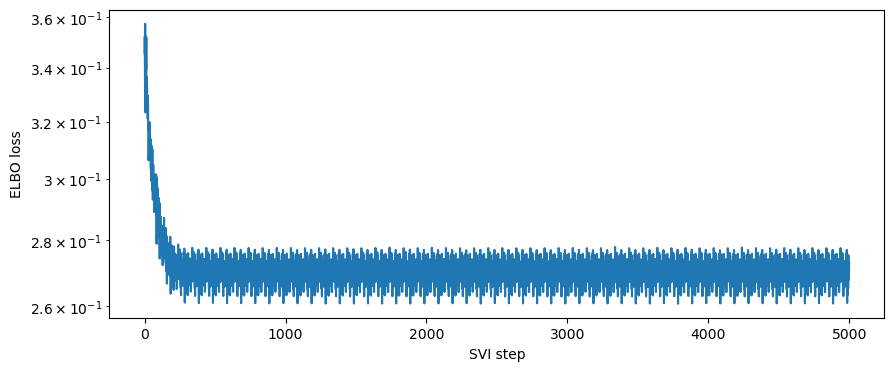

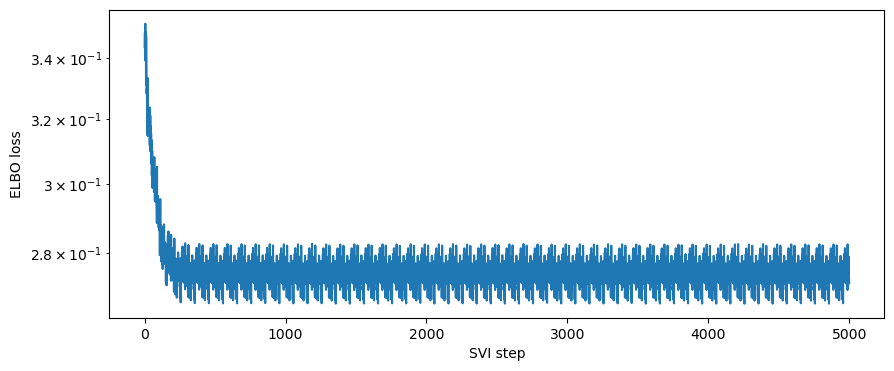

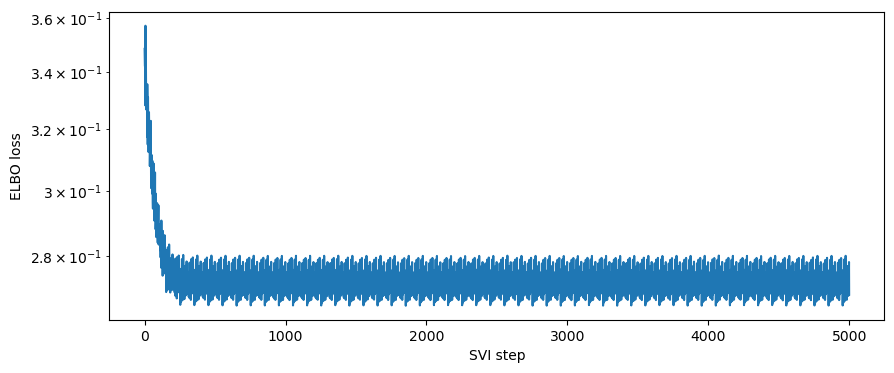

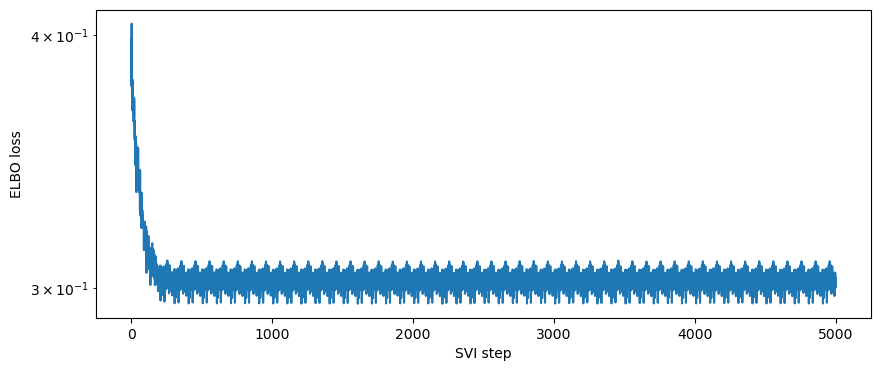

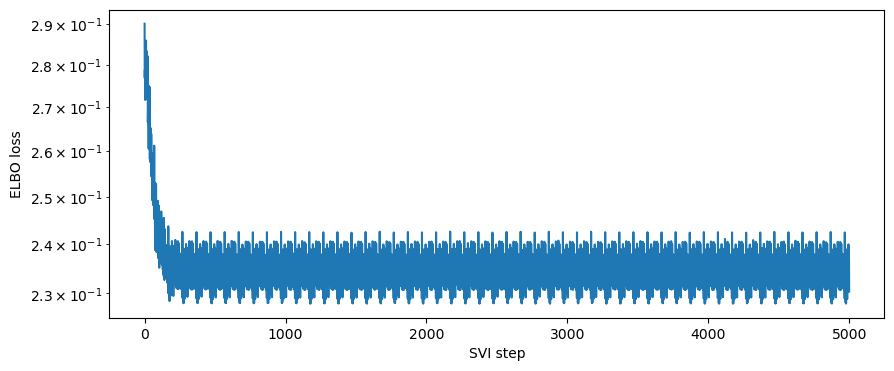

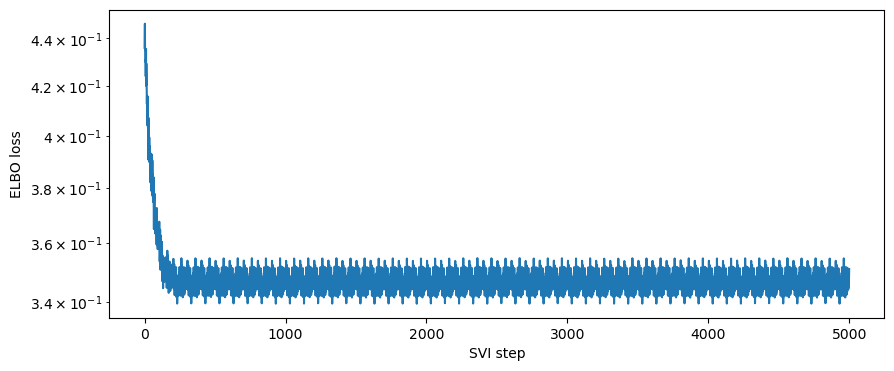

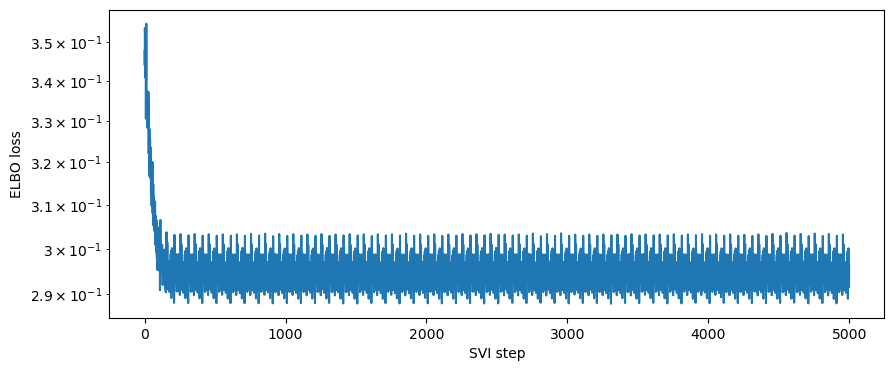

In [10]:
for header_name in filename_list_cov:
    dictionary = post_analysis.read_post_analysis(header_name)

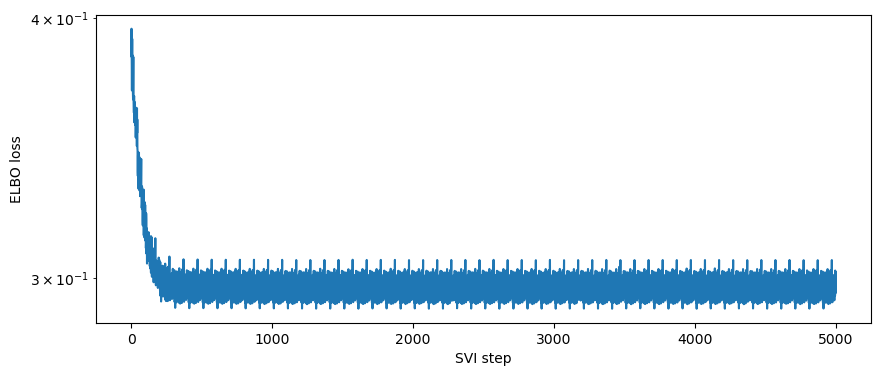

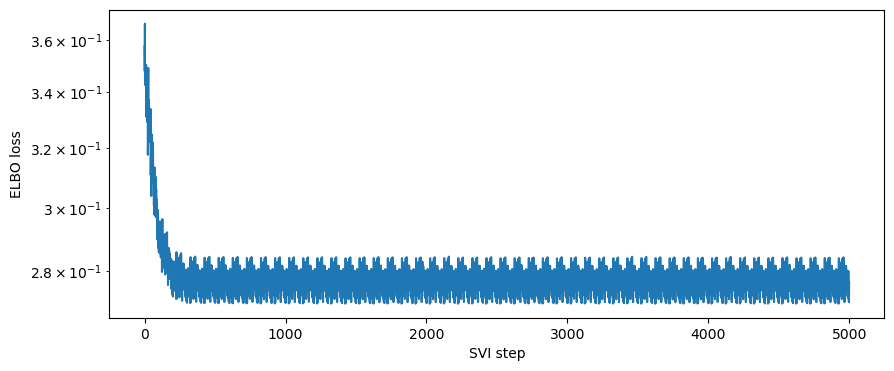

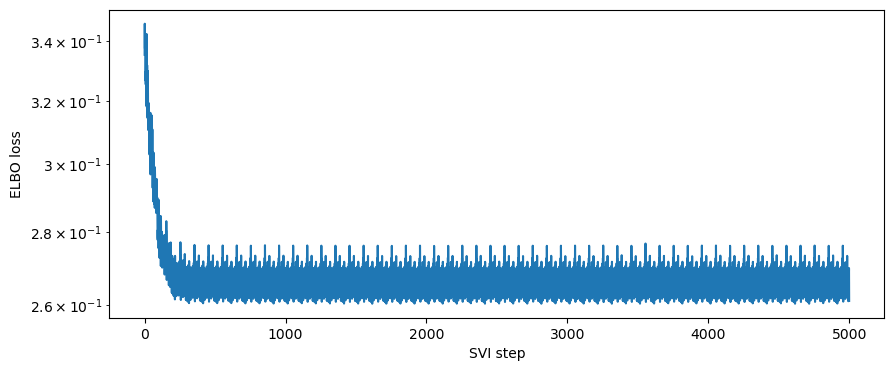

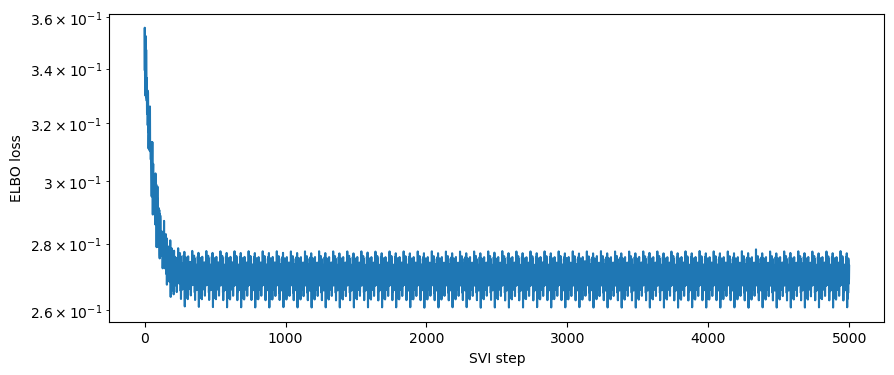

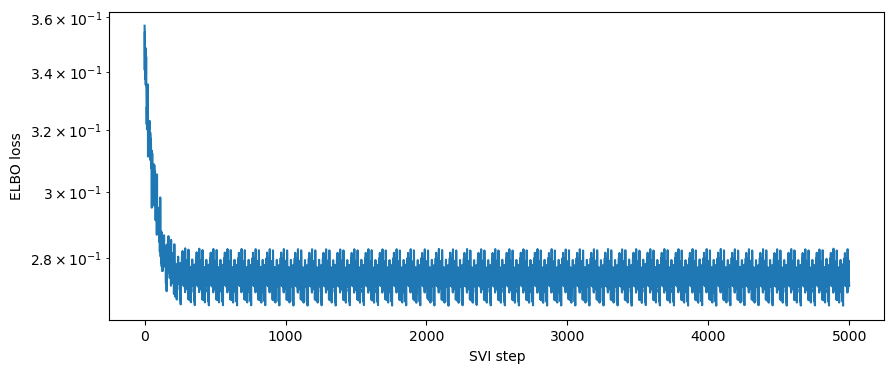

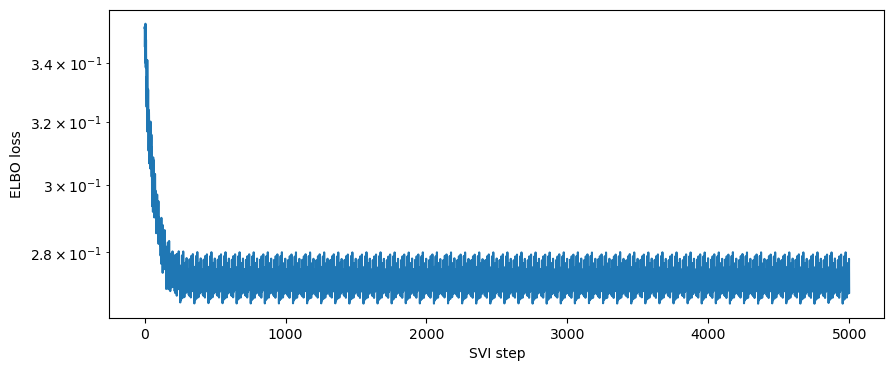

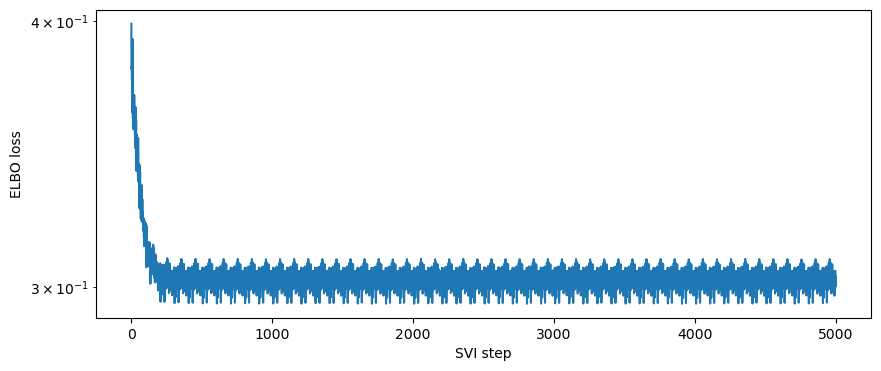

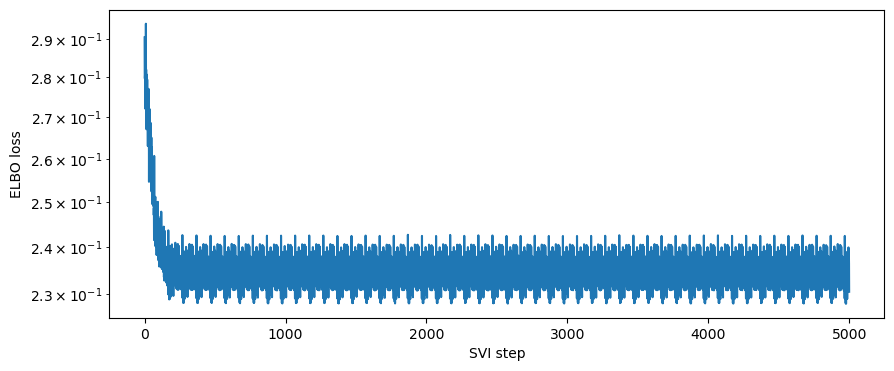

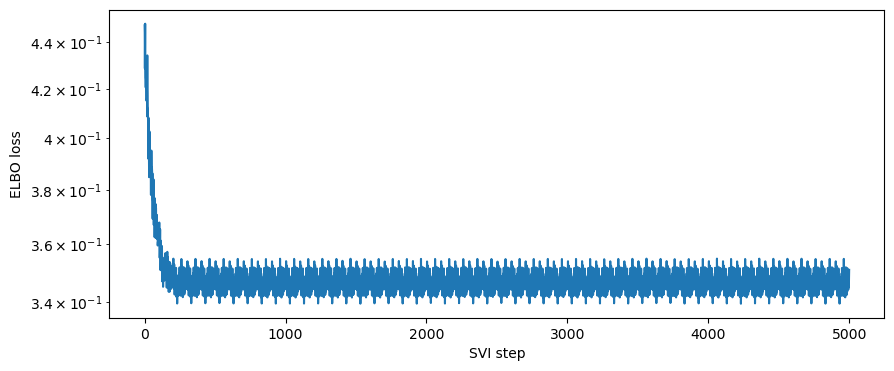

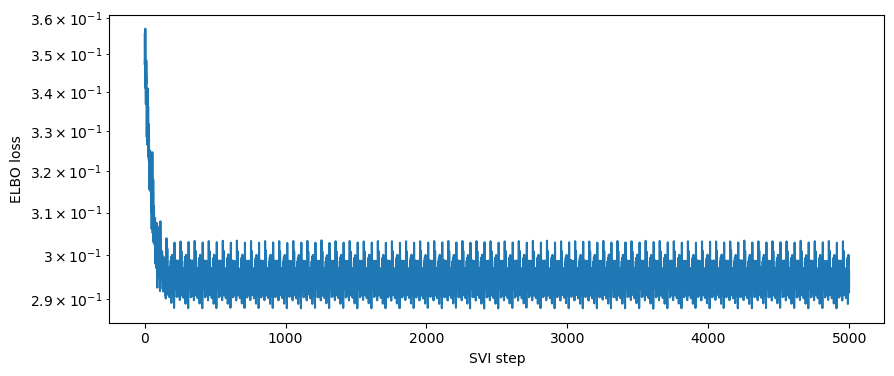

In [11]:
for header_name in filename_list_nn:
    dictionary = post_analysis.read_post_analysis(header_name)

In [7]:
list_of_list = []

for header_name in filename_list_cov:
    dictionary = post_analysis.read_model(header_name)
    
    beat_cov_trans = post_analysis.get_beta_cov_trans(dictionary)

    list_of_list.append(['cov', header_name, beat_cov_trans])
    
for header_name in filename_list_nn:
    dictionary = post_analysis.read_model(header_name)
    
    beat_cov_trans = post_analysis.get_beta_cov_trans(dictionary, name = 'weight')

    list_of_list.append(['neural_net', header_name, beat_cov_trans])

In [14]:
df = pd.DataFrame(list_of_list, columns = ["type", "header", "beta_cov_trans"])

In [17]:
df["header"] = df["header"].str.split("/", expand = True)[9]

In [34]:
df["phyloP_lower"] = df["header"].str.split("_", expand = True)[2]
df["phyloP_upper"] = df["header"].str.split("_", expand = True)[3]

df["phyloP"] = (df["phyloP_lower"].astype(float) + df["phyloP_upper"].astype(float))/2

In [31]:
for i in range(9):
    df["beta_cov_" + str(i)] = [float(x[0][i]) for x in df["beta_cov_trans"]]

In [36]:
df

,type,header,beta_cov_trans,phyloP_lower,phyloP_upper,beta_cov_0,beta_cov_1,beta_cov_2,beta_cov_3,beta_cov_4,beta_cov_5,beta_cov_6,beta_cov_7,beta_cov_8,phyloP
0,cov,gene_edges_0.0_0.1_chr_2_sample_10000000_chunk...,"[[tensor(0.0204), tensor(0.0291), tensor(0.038...",0.0,0.1,0.020431,0.029117,0.038525,0.049403,0.062112,0.080808,0.115203,0.191757,0.308720,0.05
1,cov,gene_edges_0.1_0.2_chr_2_sample_10000000_chunk...,"[[tensor(0.0418), tensor(0.0533), tensor(0.064...",0.1,0.2,0.041769,0.053321,0.064408,0.076869,0.090161,0.111398,0.153477,0.229778,0.369890,0.15
2,cov,gene_edges_0.2_0.3_chr_2_sample_10000000_chunk...,"[[tensor(0.0540), tensor(0.0652), tensor(0.077...",0.2,0.3,0.054029,0.065162,0.077741,0.091679,0.107518,0.129572,0.179834,0.273982,0.415614,0.25
3,cov,gene_edges_0.3_0.4_chr_2_sample_10000000_chunk...,"[[tensor(0.0574), tensor(0.0688), tensor(0.081...",0.3,0.4,0.057373,0.068793,0.081294,0.097176,0.117500,0.149931,0.211359,0.352822,0.543703,0.35
4,cov,gene_edges_0.4_0.5_chr_2_sample_10000000_chunk...,"[[tensor(0.0577), tensor(0.0745), tensor(0.090...",0.4,0.5,0.057666,0.074505,0.090664,0.111040,0.136527,0.182017,0.260309,0.464222,0.676687,0.45
5,cov,gene_edges_0.5_0.6_chr_2_sample_10000000_chunk...,"[[tensor(0.0659), tensor(0.0847), tensor(0.105...",0.5,0.6,0.065884,0.084709,0.105613,0.130166,0.160627,0.214592,0.341711,0.478340,0.895858,0.55
6,cov,gene_edges_0.6_0.7_chr_2_sample_10000000_chunk...,"[[tensor(0.0827), tensor(0.1065), tensor(0.124...",0.6,0.7,0.082717,0.106457,0.124644,0.151174,0.206002,0.280646,0.409056,0.803070,1.051874,0.65
7,cov,gene_edges_0.7_0.8_chr_2_sample_10000000_chunk...,"[[tensor(0.1896), tensor(0.2292), tensor(0.270...",0.7,0.8,0.189551,0.229183,0.270042,0.318605,0.401351,0.506511,0.668111,1.153909,1.849791,0.75
8,cov,gene_edges_0.8_0.9_chr_2_sample_10000000_chunk...,"[[tensor(0.1010), tensor(0.1804), tensor(0.250...",0.8,0.9,0.100955,0.180426,0.250312,0.339821,0.389233,0.511086,0.671975,1.099273,1.730667,0.85
9,cov,gene_edges_0.9_1.0_chr_2_sample_10000000_chunk...,"[[tensor(0.2767), tensor(0.4213), tensor(0.515...",0.9,1.0,0.276710,0.421252,0.514993,0.629737,0.863168,1.031124,1.291528,1.861701,2.744601,0.95


### plot largest beta bin to middle phyloP

In [37]:
beta_column_list = []

for i in range(9):
    beta_column_list.append("beta_cov_" + str(i))

df_melt = pd.melt(df, id_vars=['phyloP', 'type'], value_vars=beta_column_list)

In [38]:
df_melt

,phyloP,type,variable,value
0,0.05,cov,beta_cov_0,0.020431
1,0.15,cov,beta_cov_0,0.041769
2,0.25,cov,beta_cov_0,0.054029
3,0.35,cov,beta_cov_0,0.057373
4,0.45,cov,beta_cov_0,0.057666
...,...,...,...,...
175,0.55,neural_net,beta_cov_8,0.873323
176,0.65,neural_net,beta_cov_8,1.051196
177,0.75,neural_net,beta_cov_8,1.792190
178,0.85,neural_net,beta_cov_8,1.800647


In [39]:
df_melt["bin"] = df_melt["variable"].str.split("_", expand = True)[2].astype(int) + 1

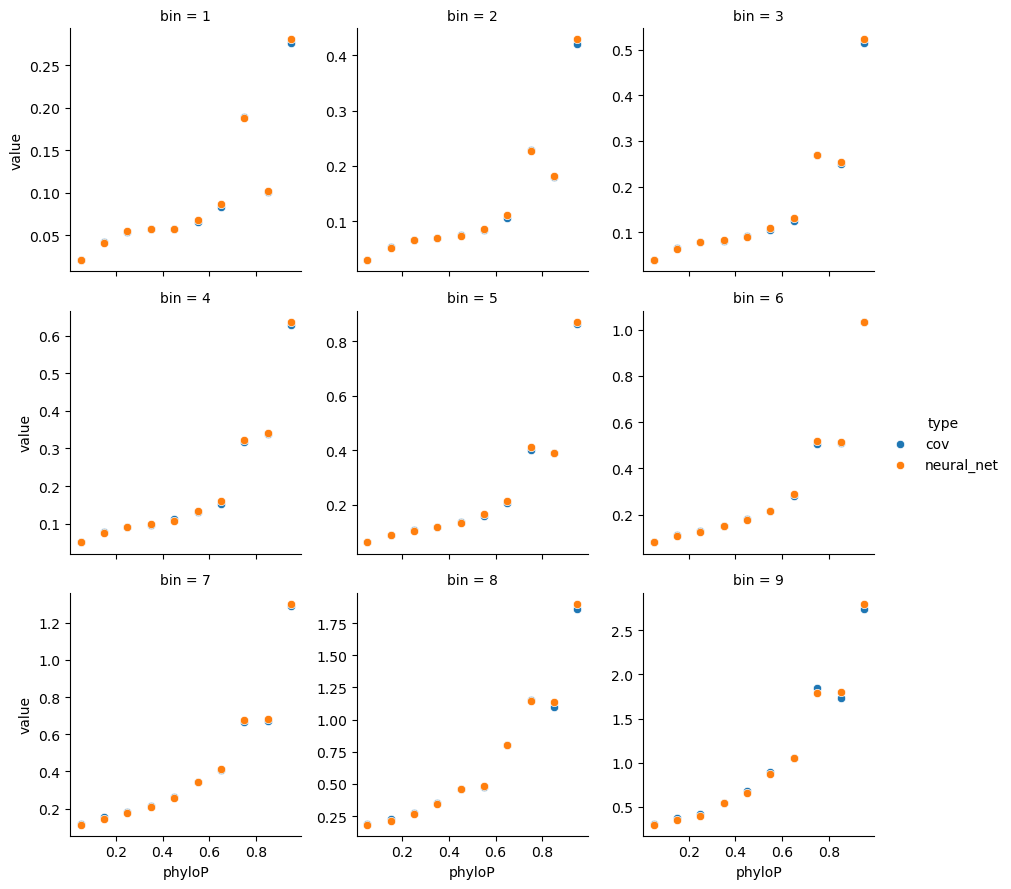

In [45]:
g = sns.FacetGrid(df_melt, col="bin", col_wrap=3, sharey = False, hue = 'type')
g.map(sns.scatterplot, "phyloP", "value")

g.add_legend()
